In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from saxskit import saxs_math, saxs_fit
from saxskit.saxs_classify import SaxsClassifier
from saxskit.saxs_regression import SaxsRegressor

## Predict populations and scattering parameters from measured data

#### Step 1. Read q (1/A) and Intensity from csv file

In [3]:
p = os.getcwd()
d, _  = os.path.split(p)
path = os.path.join(d,'examples','sample_0.csv')

q_I = np.genfromtxt (path, delimiter=",")

#### Step 2. Examine the spectrum

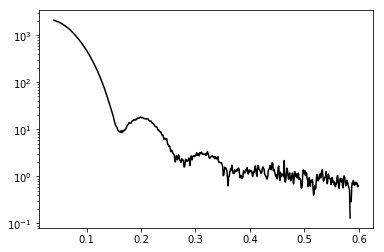

In [4]:
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.show()

#### Step 3. Calculate numerical features (profile) of the spectrum

In [5]:
features = saxs_math.profile_spectrum(q_I)
features

OrderedDict([('Imax_over_Imean', 13.181053776872366),
             ('Imax_sharpness', 1.0200591262893703),
             ('I_fluctuation', 0.0010389964263103481),
             ('logI_fluctuation', 5.9430730571972088),
             ('logI_max_over_std', 3.2213864774189336),
             ('r_fftIcentroid', 0.10056978331899331),
             ('r_fftImax', 0.0017857142857142857),
             ('q_Icentroid', 0.071982047474586974),
             ('q_logIcentroid', 0.13005159629922175),
             ('pearson_q', -0.55991024447800586),
             ('pearson_q2', -0.41978848602666091),
             ('pearson_expq', -0.51884676634956572),
             ('pearson_invexpq', 0.60128004622986864)])

#### Step 4. Predict scatterer populations

In [6]:
saxs_cls = SaxsClassifier()

populations, propability = saxs_cls.classify(features)
print('-----scatterer populations:-----')
for k,v in populations.items():
    print(k, ":", v, "  with propability: %1.3f" % (propability[k]))

-----scatterer populations:-----
unidentified : 0   with propability: 0.986
guinier_porod : 0   with propability: 0.767
spherical_normal : 1   with propability: 0.998
diffraction_peaks : 0   with propability: 0.974


The saxskit models predict that the data are identifiable and that the scatterers include one population of a normal size distribution of spherical scatterers. The models predict no diffraction peaks with a high certainty, and no Guinier-Porod like terms with a less-high certainty.

#### Step 5. Predict scattering parameters

In [7]:
saxs_reg = SaxsRegressor()

params = saxs_reg.predict_params(populations,features,q_I)
print('-----scattering parameters:-----')
for k,v in params.items():
    print(k, ":", end="")
    for n in v:
        print(" %10.3f" % (n))

-----scattering parameters:-----
r0_sphere :     26.784
sigma_sphere :      0.048


The saxskit models predict the mean sphere size (in Angstroms) and the standard deviation (fractional), assuming a normal size distribution. 

Parameters related to intensity (the intensities of the noise floor and spherical scattering) are now computed by constrained least-squares fitting:

In [8]:
sxf = saxs_fit.SaxsFitter(q_I,populations)
params, report = sxf.fit_intensity_params(params)
print('-----scattering and intensity parameters:-----')
for k,v in params.items():
    print(k, ":", end="")
    for n in v:
        print(" %10.3f" % (n))

-----scattering and intensity parameters:-----
I0_floor :      0.658
I0_sphere :   2626.538
r0_sphere :     26.784
sigma_sphere :      0.048


#### Step 6. See how predicted parameters reproduce measured spectrum

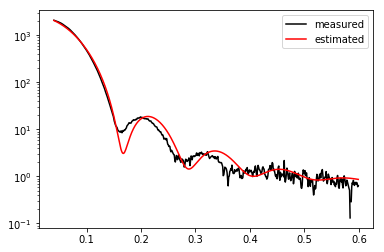

In [9]:
I_estimate = saxs_math.compute_saxs(q_I[:,0],populations,params)
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.semilogy(q_I[:,0],I_estimate,'-r')
plt.legend(['measured','estimated'])
plt.show()

#### Step 7. Refine the parameters by least-squares fitting the spectrum

In [10]:
params_opt, rpt = sxf.fit(params)
params_opt
print('-----scattering and intensity parameters:-----')
for k,v in params_opt.items():
    print(k, ":", end="")
    for n in v:
        print(" %10.3f" % (n))

-----scattering and intensity parameters:-----
I0_floor :      0.528
I0_sphere :   2950.512
r0_sphere :     27.410
sigma_sphere :      0.088


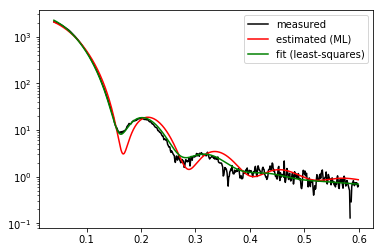

In [11]:
I_opt = saxs_math.compute_saxs(q_I[:,0],populations,params_opt)
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.semilogy(q_I[:,0],I_estimate,'-r')
plt.semilogy(q_I[:,0],I_opt,'-g')
plt.legend(['measured','estimated (ML)','fit (least-squares)'])
plt.show()